# Jonathan Halverson
# Tuesday, February 13, 2018
# Linear regression with a closer look at indicator variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
df_raw = pd.read_csv('../spark/mllib/Sacramentorealestatetransactions.csv', parse_dates=['sale_date'], header=0)
df_raw.rename(columns = {'sq__ft':'sqft'}, inplace = True)
df_raw = df_raw.astype({'beds':float}).astype({'baths':float}).astype({'sqft':float})
df_raw.head()

,street,city,zip,state,beds,baths,sqft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2.0,1.0,836.0,Residential,2008-05-21 04:00:00,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3.0,1.0,1167.0,Residential,2008-05-21 04:00:00,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2.0,1.0,796.0,Residential,2008-05-21 04:00:00,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2.0,1.0,852.0,Residential,2008-05-21 04:00:00,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2.0,1.0,797.0,Residential,2008-05-21 04:00:00,81900,38.519470,-121.435768


In [3]:
df = df_raw.drop(['street', 'state', 'city', 'sale_date', 'zip', 'latitude', 'longitude'], axis=1)

In [4]:
df.head()

,beds,baths,sqft,type,price
0,2.0,1.0,836.0,Residential,59222
1,3.0,1.0,1167.0,Residential,68212
2,2.0,1.0,796.0,Residential,68880
3,2.0,1.0,852.0,Residential,69307
4,2.0,1.0,797.0,Residential,81900


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 5 columns):
beds     985 non-null float64
baths    985 non-null float64
sqft     985 non-null float64
type     985 non-null object
price    985 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 38.5+ KB


Clean data by removing rows where there are three zeros:

In [6]:
df.shape

(985, 5)

In [7]:
msk = (df.sqft == 0) & (df.beds == 0) & (df.baths == 0)
df = df[~msk]

In [8]:
df.shape

(877, 5)

In [9]:
df['type'].value_counts()

Residential     818
Condo            46
Multi-Family     13
Name: type, dtype: int64

In [10]:
df.head()

,beds,baths,sqft,type,price
0,2.0,1.0,836.0,Residential,59222
1,3.0,1.0,1167.0,Residential,68212
2,2.0,1.0,796.0,Residential,68880
3,2.0,1.0,852.0,Residential,69307
4,2.0,1.0,797.0,Residential,81900


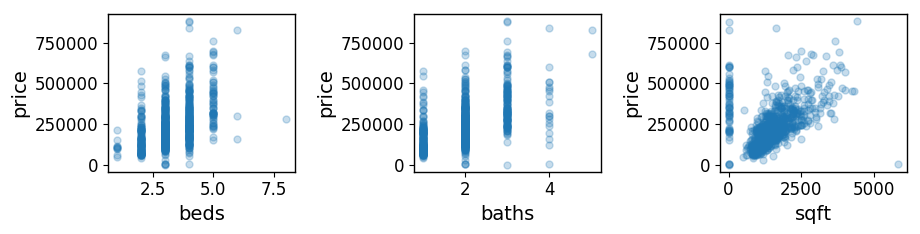

In [11]:
fig = plt.figure(figsize=(9.5, 2.5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(df.beds, df.price, alpha=0.25, s=25)
ax1.set_xlabel('beds')
ax1.set_ylabel('price')
ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(df.baths, df.price, alpha=0.25, s=25)
ax2.set_xlabel('baths')
ax2.set_ylabel('price')
ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(df.sqft, df.price, alpha=0.25, s=25)
ax3.set_xlabel('sqft')
ax3.set_ylabel('price')
plt.tight_layout()

We see that there are several records where sqft is zero. We will replace those values using a model based on the number of beds and baths.

### Impute values for zero sqft based on linear model

In [12]:
df_nonzero_sqft = df[df.sqft > 0].copy()
df_nonzero_sqft.sort_values('sqft').head()

,beds,baths,sqft,type,price
336,1.0,1.0,484.0,Condo,48000
292,2.0,1.0,539.0,Residential,334000
18,2.0,1.0,588.0,Residential,120000
168,2.0,1.0,610.0,Residential,93675
868,1.0,1.0,611.0,Condo,60000


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = df_nonzero_sqft[['beds', 'baths']]
y = df_nonzero_sqft.sqft
lr_non_zero = LinearRegression().fit(X, y)
y_pred = lr_non_zero.predict(X)
r2_score(y, y_pred), np.sqrt(mean_squared_error(y, y_pred))

(0.6107810766053221, 413.89933044266706)

Use model to replace zero values:

In [14]:
def replace_zero_sqft(row):
     if row.sqft > 0.0:
          return row.sqft
     else:
          return lr_non_zero.predict([[row.beds, row.baths]])[0]

In [15]:
df.sqft = df.apply(lambda row: replace_zero_sqft(row), axis=1)

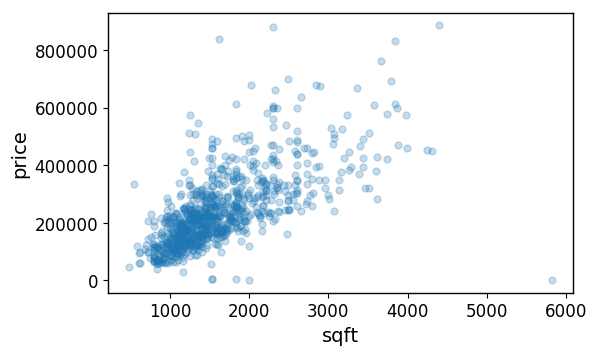

In [16]:
plt.scatter(df.sqft, df.price, alpha=0.25, s=25)
plt.xlabel('sqft')
plt.ylabel('price')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877 entries, 0 to 984
Data columns (total 5 columns):
beds     877 non-null float64
baths    877 non-null float64
sqft     877 non-null float64
type     877 non-null object
price    877 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 81.1+ KB


In [18]:
df.corr()

,beds,baths,sqft,price
beds,1.000000,0.659514,0.711213,0.450966
baths,0.659514,1.000000,0.740523,0.524377
sqft,0.711213,0.740523,1.000000,0.675098
price,0.450966,0.524377,0.675098,1.000000


In [19]:
num_features = ['beds', 'baths', 'sqft']

In [20]:
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()
numeric_std = std_sc.fit_transform(df[num_features].values)

For linear regression we use reference coding drop_first=True:

In [21]:
indicators = pd.get_dummies(df['type'], drop_first=True)
X = np.hstack((numeric_std, indicators.values))
y = df.price.values

In [22]:
X[:5]

array([[-1.46987446, -1.4630568 , -1.17845649,  0.        ,  1.        ],
       [-0.31271117, -1.4630568 , -0.67781881,  0.        ,  1.        ],
       [-1.46987446, -1.4630568 , -1.23895651,  0.        ,  1.        ],
       [-1.46987446, -1.4630568 , -1.15425648,  0.        ,  1.        ],
       [-1.46987446, -1.4630568 , -1.23744401,  0.        ,  1.        ]])

In [23]:
X.mean(axis=0)

array([ -6.22205948e-17,  -1.35122497e-16,   2.91164533e-17,
         1.48232611e-02,   9.32725200e-01])

In [24]:
X.shape

(877, 5)

In [25]:
lr = LinearRegression()
lr = lr.fit(X, y)
y_pred = lr.predict(X)

In [26]:
r2_score(y, y_pred), np.sqrt(mean_squared_error(y, y_pred))

(0.46811532947128853, 94875.903748723373)

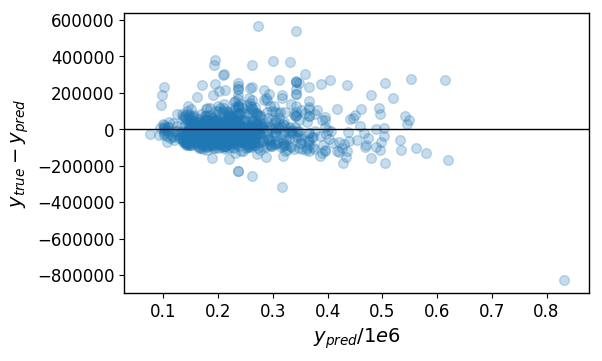

In [27]:
plt.scatter(y_pred / 1e6, y - y_pred, alpha=0.25)
plt.axhline(y=0, c='k')
plt.xlabel(r'$y_{pred}/1e6$')
plt.ylabel(r'$y_{true} - y_{pred}$')

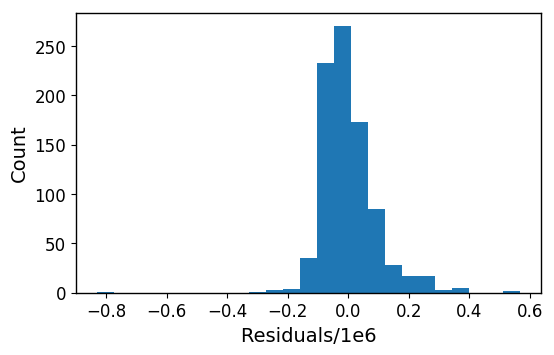

In [28]:
plt.hist((y - y_pred)/1e6, bins=25)
plt.xlabel('Residuals/1e6')
plt.ylabel('Count')

Ridge regression gave no improvement over linear. Would need polynomial features for instance for this to have an effect.

### Random Forest

We use one-hot encoding for this tree method:

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
indicators = pd.get_dummies(df['type'], drop_first=False)
X = np.hstack((numeric_std, indicators.values))
y = df.price.values

In [31]:
rf = RandomForestRegressor(n_estimators=100).fit(X, y)
y_pred = rf.predict(X)
r2_score(y, y_pred), np.sqrt(mean_squared_error(y, y_pred))

(0.84434271793503879, 51325.348919577569)

In [32]:
cols = num_features + indicators.columns.tolist()
cols

['beds', 'baths', 'sqft', 'Condo', 'Multi-Family', 'Residential']

In [33]:
rf.feature_importances_

array([ 0.04981833,  0.0582342 ,  0.87170507,  0.0034407 ,  0.00795835,
        0.00884335])

In [34]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

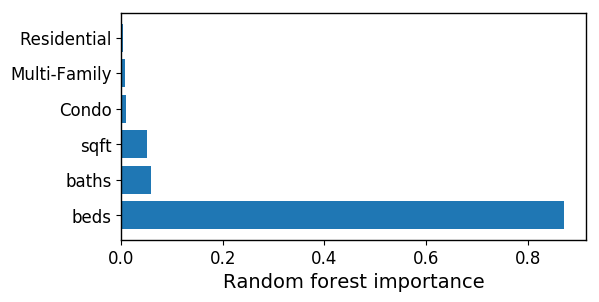

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.barh(range(len(cols)), importances[indices],  align='center')
plt.yticks(range(len(cols)), cols, rotation=0)
plt.xlabel('Random forest importance')

### Statsmodels

Return to reference coding:

In [36]:
indicators = pd.get_dummies(df['type'], drop_first=True)
X = np.hstack((numeric_std, indicators.values))
y = df.price.values

In [37]:
xf = pd.DataFrame(X, columns=num_features + ['multifamily', 'residential']).copy()
xf['price'] = y
xf.head()

,beds,baths,sqft,multifamily,residential,price
0,-1.469874,-1.463057,-1.178456,0.0,1.0,59222
1,-0.312711,-1.463057,-0.677819,0.0,1.0,68212
2,-1.469874,-1.463057,-1.238957,0.0,1.0,68880
3,-1.469874,-1.463057,-1.154256,0.0,1.0,69307
4,-1.469874,-1.463057,-1.237444,0.0,1.0,81900


In [38]:
import statsmodels.formula.api as smf

result = smf.ols(formula='price ~ beds + baths + sqft + multifamily + residential', data=xf).fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     153.3
Date:                Wed, 14 Feb 2018   Prob (F-statistic):          8.66e-117
Time:                        13:14:23   Log-Likelihood:                -11295.
No. Observations:                 877   AIC:                         2.260e+04
Df Residuals:                     871   BIC:                         2.263e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     2.09e+05    1.5e+04     13.891      